In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Scikit-learn for preprocessing

from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# libraries for imbalance dataset
from imblearn.pipeline import Pipeline  # IMPORTANT: use imblearn's Pipeline
from imblearn.over_sampling import SMOTE


# Libraries for models and metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix


In [3]:
# 1) Load the dataset (semicolon-separated in UCI files)
#    Use the correct filename you downloaded, e.g.:
#    - 'bank-full.csv' (older dataset)
#    - 'bank-additional-full.csv' (newer dataset with more features)
df = pd.read_csv('bank-additional-full.csv', sep=';')  # adjust the filename if needed

# 2) Target and columns to drop
target_col = 'target'               # target column name in this dataset
drop_cols = ['duration']       # leakage; must be removed from features

In [4]:
df.shape

(41188, 21)

In [5]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [6]:
df.rename(columns={'y': 'target'},inplace = True)

In [7]:
df['poutcome'].value_counts()

poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

In [8]:
# (Optional) Map the target to 0/1 if it is 'yes'/'no'
if df[target_col].dtype == 'O':
    df['target'] = df[target_col].map({'yes': 1, 'no': 0}).astype('int64')
else:
    df['target'] = df[target_col]

In [9]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [10]:

# Ordinal (with explicit order)
ordinal_cols = ['education', 'month']
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
month_order     = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
ordinal_categories = [education_order, month_order]

# Nominal (one-hot)
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Numeric (scale)  -- 'duration' is leakage and will be dropped from X
numeric_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']



In [11]:

# 4) Build X/y and drop leakage

X = df.drop(columns=['target', 'duration'])  # drop 'duration' (leakage)
y = df['target']


# (Optional) Sanity checks

expected_cols = set(ordinal_cols) | set(nominal_cols) | set(numeric_cols)
print("Missing (referenced but not in df):", expected_cols - set(X.columns))
print("Unexpected (in X but not referenced):", set(X.columns) - expected_cols)


# --- 2) Split first (avoid leakage) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Missing (referenced but not in df): {'balance', 'day'}
Unexpected (in X but not referenced): {'cons.conf.idx', 'emp.var.rate', 'cons.price.idx', 'day_of_week', 'euribor3m', 'nr.employed'}


In [12]:
ordinal_enc = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1

    )

onehot_enc = OneHotEncoder(
    handle_unknown='ignore'
    )

num_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_enc, ordinal_cols),
        ('nom', onehot_enc, nominal_cols),
        ('num', num_scaler, numeric_cols)
    ],
    remainder='drop'
)


In [13]:

#  SMOTE (tuneable) ---
# 'sampling_strategy' controls minority target proportion after resampling. 'auto' -> balance to majority.
smote = SMOTE(sampling_strategy=0.8, random_state=42)


In [14]:
# pipeline




pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('model', LogisticRegression(max_iter=2000))  # placeholder; overridden in GridSearch
])



In [15]:
# checking the shape before and after SMOTE
X_train_prep = preprocessor.fit_transform(X_train)
print("After preprocessing:", X_train_prep.shape)

X_resampled, y_resampled = smote.fit_resample(X_train_prep, y_train)
print("After SMOTE:", X_resampled.shape, y_resampled.shape)


ValueError: A given column is not a column of the dataframe

In [20]:
# A) Logistic Regression (no class_weight when using SMOTE)
param_grids=[]
param_grids.append({
    'model': [LogisticRegression(max_iter=2000, solver='liblinear')],
    'model__C': [0.1, 1, 3, 10],
    'model__penalty': ['l1', 'l2'],
    # Optional: tune SMOTE too
    'smote__k_neighbors': [3, 5],  # default 5; lower can help when minority is tiny
    'smote__sampling_strategy': ['auto', 0.7, 1.0]  # 1.0 balance, 0.7 means minority = 70% of majority
})

In [26]:
# --- Actual pipeline + CV ---
pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote),
    ('model', LogisticRegression(max_iter=2000))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc')
random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grids,
    n_iter=10,              # number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1               # use all cores for speed
)

#grid.fit(X_train, y_train)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)


Best params: {'smote__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'model__penalty': 'l1', 'model__C': 0.1, 'model': LogisticRegression(max_iter=2000, solver='liblinear')}
Best CV score: 0.7403922290806012


In [ ]:
# B) Decision Tree
param_grids.append({
    'model': [DecisionTreeClassifier(random_state=42)],
    'model__max_depth': [None, 4, 6, 10],
    'model__min_samples_split': [2, 10, 30],
    'model__min_samples_leaf': [1, 3, 10],
    'model__criterion': ['gini', 'entropy'],
    'smote__k_neighbors': [3, 5],
    'smote__sampling_strategy': ['auto', 1.0]
})

# C) Random Forest
param_grids.append({
    'model': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'model__n_estimators': [300, 500],
    'model__max_depth': [None, 8, 12],
    'model__min_samples_split': [2, 10, 30],
    'model__min_samples_leaf': [1, 3, 10],
    'model__max_features': ['sqrt', 0.5],
    'smote__k_neighbors': [3, 5],
    'smote__sampling_strategy': ['auto', 1.0]
})

# D) Gradient Boosting
param_grids.append({
    'model': [GradientBoostingClassifier(random_state=42)],
    'model__n_estimators': [200, 400],
    'mo del__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3],
    'model__min_samples_leaf': [1, 5],
    'model__subsample': [1.0, 0.8],
    'smote__k_neighbors': [3, 5],
    'smote__sampling_strategy': ['auto', 1.0]
})

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grids,
    n_iter=10,              # number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1               # use all cores for speed
)

#grid.fit(X_train, y_train)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Best CV ROC AUC:", random_search.best_score_)


Best params: {'smote__sampling_strategy': 'auto', 'smote__k_neighbors': 3, 'model__subsample': 0.8, 'model__n_estimators': 400, 'model__min_samples_leaf': 1, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model': GradientBoostingClassifier(random_state=42)}
Best CV score: 0.7793979686847224
Best CV ROC AUC: 0.7793979686847224


In [33]:
best_model = random_search.best_estimator_.named_steps['model']
print(best_model)


GradientBoostingClassifier(n_estimators=400, random_state=42, subsample=0.8)


In [35]:
smote_best = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)

gb_best = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=1,
    subsample=0.8,
    random_state=42
)

best_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', smote_best),
    ('model', gb_best)
])

best_pipe.fit(X_train, y_train)  # retrain with best params

,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ord', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Test ROC AUC: 0.7864807951582184

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.59      0.28      0.38      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.63      0.66      9043
weighted avg       0.87      0.89      0.88      9043



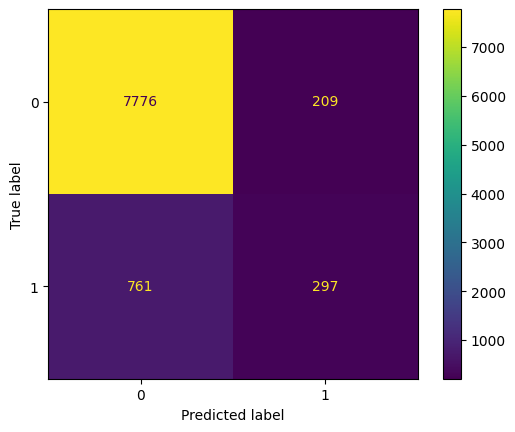

In [36]:
# Predict on test set
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]  # probability for ROC AUC

# Print metrics
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_pipe, X_test, y_test)



In [42]:
# Goal is to lower the false negative (People who actually said yes (1) but model predicted No, missed oppurtunity
# we do this by lowering the threshold from 0.5 -> 0.3
y_proba = best_pipe.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.2).astype(int)  # try 0.3 instead of 0.5

In [43]:
print("ROC AUC:", roc_auc_score(y_test, y_proba))  # unchanged, threshold-independent
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))

ROC AUC: 0.7864807951582184

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      7985
           1       0.30      0.63      0.41      1058

    accuracy                           0.79      9043
   macro avg       0.62      0.72      0.64      9043
weighted avg       0.87      0.79      0.82      9043


Confusion Matrix:
 [[6436 1549]
 [ 388  670]]


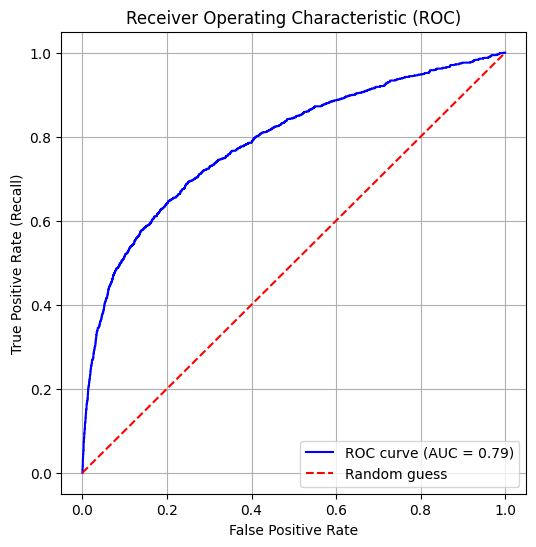

In [46]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()